In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, classification_report
from joblib import dump
from tabulate import tabulate
%matplotlib inline

In [110]:
# Load titanic.csv
titanic_df = pd.read_csv('titanic.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Processing Data

In [111]:
# drop the least relevant columns from the dataset (based on previous analysis)
titanic_df.drop(columns=['PassengerId','Name','Ticket','Cabin'], axis=1, inplace=True)
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [112]:
# impute missing values
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].median())
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0])
missing_values_after =  titanic_df.isnull().sum()
print(f"\nMissing values after imputation:\n {missing_values_after}")


Missing values after imputation:
 Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [113]:
# Encoding categorical features
nominal_features = ['Embarked', 'Sex','Pclass']
onehot_encoder = OneHotEncoder()
df_onehot_encoded = onehot_encoder.fit_transform(titanic_df[nominal_features])
df_onehot_encoded_df = pd.DataFrame(df_onehot_encoded.toarray(), columns=onehot_encoder.get_feature_names_out())

# Drop original nominal columns
titanic_df.drop(columns=nominal_features, axis=1, inplace=True)

titanic_df = pd.concat([titanic_df, df_onehot_encoded_df], axis=1)
titanic_df.head()

,Survived,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,0,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [114]:
# split data into X and y
r = 42

X = titanic_df.drop(columns=['Survived'], axis=1)
y = titanic_df['Survived']

# split data into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)

In [115]:
# for non-Gaussian features, use MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert the scaled data back to a DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

In [116]:
# apply winsorization to features separately to address outliers
for column in X_train:
    X_train[column] = mstats.winsorize(X_train[column], limits=(0.10, 0.10))

for column in X_test:
    X_test[column] = mstats.winsorize(X_test[column], limits=(0.10, 0.10))

In [121]:
# create the confusion matrix
titanic_df_transformed = pd.concat([X_test,X_train, y_test,y_train], axis=1)

corr_matrix = titanic_df.corr()
corr_matrix

,Survived,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
Survived,1.000000,-0.064910,-0.035322,0.081629,0.257307,0.168240,0.003650,-0.149683,0.543351,-0.543351,0.285904,0.093349,-0.322308
Age,-0.064910,1.000000,-0.233296,-0.172482,0.096688,0.030248,-0.031415,-0.006729,-0.081163,0.081163,0.323896,0.015831,-0.291955
SibSp,-0.035322,-0.233296,1.000000,0.414838,0.159651,-0.059528,-0.026354,0.068734,0.114631,-0.114631,-0.054582,-0.055932,0.092548
Parch,0.081629,-0.172482,0.414838,1.000000,0.216225,-0.011069,-0.081228,0.060814,0.245489,-0.245489,-0.017633,-0.000734,0.015790
Fare,0.257307,0.096688,0.159651,0.216225,1.000000,0.269335,-0.117216,-0.162184,0.182333,-0.182333,0.591711,-0.118557,-0.413333
Embarked_C,0.168240,0.030248,-0.059528,-0.011069,0.269335,1.000000,-0.148258,-0.782742,0.082853,-0.082853,0.296423,-0.125416,-0.153329
Embarked_Q,0.003650,-0.031415,-0.026354,-0.081228,-0.117216,-0.148258,1.000000,-0.499421,0.074115,-0.074115,-0.155342,-0.127301,0.237449
Embarked_S,-0.149683,-0.006729,0.068734,0.060814,-0.162184,-0.782742,-0.499421,1.000000,-0.119224,0.119224,-0.161921,0.189980,-0.015104
Sex_female,0.543351,-0.081163,0.114631,0.245489,0.182333,0.082853,0.074115,-0.119224,1.000000,-1.000000,0.098013,0.064746,-0.137143
Sex_male,-0.543351,0.081163,-0.114631,-0.245489,-0.182333,-0.082853,-0.074115,0.119224,-1.000000,1.000000,-0.098013,-0.064746,0.137143


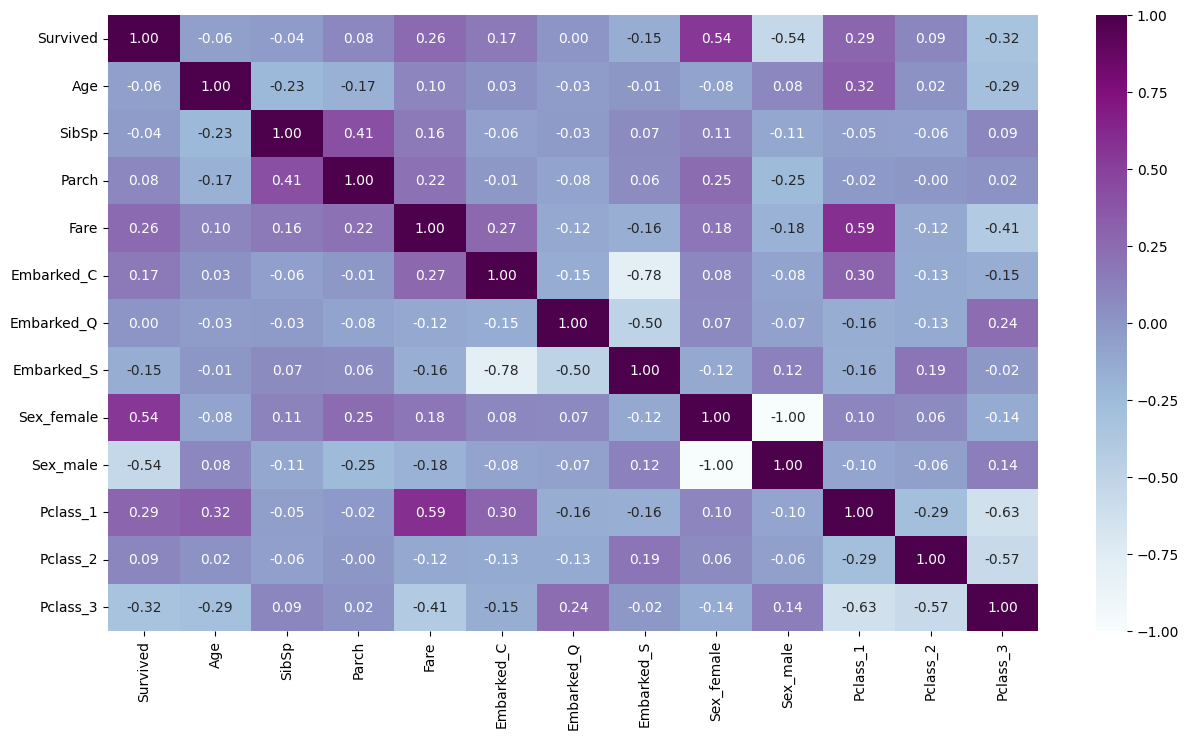

In [122]:
plt.figure(figsize=(15, 8))  # Adjust width and height as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='BuPu')
plt.show()

According to the heatmap, sex_female & sex_male have the strongest relationships with the survival of passengers.

## Models

In [123]:
# Bagged Tree
bagged_tree = BaggingClassifier(random_state=r)
bagged_tree.fit(X_train, y_train)

# Random Forest
random_forest = RandomForestClassifier(random_state=r)
random_forest.fit(X_train, y_train)

# Boosted Tree
boosted_tree = AdaBoostClassifier(random_state=r)
boosted_tree.fit(X_train, y_train)

/Users/lalehhaidari/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(random_state=42)

## Feature Importance in Random Forest

In [124]:
# Finding the important features using the built-in Gini importance
feature_names = X.columns
importances = random_forest.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
feature_imp_df

,Feature,Gini Importance
3,Fare,0.267011
0,Age,0.229309
8,Sex_male,0.150852
7,Sex_female,0.145178
11,Pclass_3,0.052816
2,Parch,0.041424
9,Pclass_1,0.026448
6,Embarked_S,0.024491
1,SibSp,0.024228
10,Pclass_2,0.021208


In [125]:
# Find the most important feature
most_important_feature_rf = features[importances.argmax()]
print(f"The most important feature in Random Forest is: {most_important_feature_rf}")

The most important feature in Random Forest is: Fare


Text(0, 0.5, 'Features')

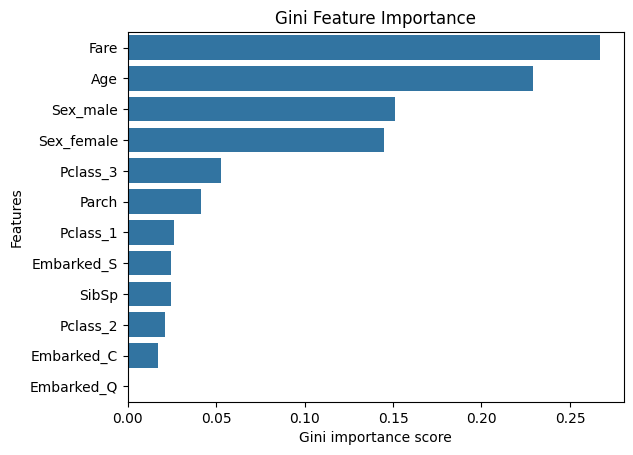

In [120]:
# Creating a seaborn bar plot of the feature importances
sns.barplot(x=feature_imp_df['Gini Importance'],y=feature_imp_df['Feature'],data=feature_imp_df)
plt.title("Gini Feature Importance")
plt.xlabel("Gini importance score")
plt.ylabel("Features")

This result differs from the heatmap, which indicates that Sex has the strongest correlation with Survival.

## Parameter tuning the Random Forest model

In [105]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15]
}

# Grid search for best parameters
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters for Random Forest: {best_params}")

Best parameters for Random Forest: {'max_depth': 5, 'n_estimators': 150}


## Model Evaluation

In [161]:
from sklearn.metrics import accuracy_score

# Evaluate models
models = {
    'Bagged Tree': bagged_tree,
    'Random Forest': random_forest,
    'Boosted Tree': boosted_tree
}

In [162]:
accuracies = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"Accuracy of {name}: {acc}")

Accuracy of Bagged Tree: 0.7932960893854749
Accuracy of Random Forest: 0.8044692737430168
Accuracy of Boosted Tree: 0.8156424581005587


In [165]:
# identify the best performing model
best_model_name = max(accuracies, key=accuracies.get)
best_model = models[best_model_name]

# report the best performing model and its parameters
print("\nThe best performing model is:", best_model_name)
print(f"Accuracy of the {best_model_name} model: {accuracies[best_model_name]}")

# report parameters of the best model
if best_model_name == 'Random Forest':
    print("\nBest parameters:")
    print("n_estimators:", best_params['n_estimators'])
    print("max_depth:", best_params['max_depth'])
else:
    print("\nBest parameters:")
    print("n_estimators:", boosted_tree.n_estimators)
    print("base estimator:", boosted_tree.estimator_)


The best performing model is: Boosted Tree
Accuracy of the Boosted Tree model: 0.8156424581005587

Best parameters:
n_estimators: 50
base estimator: DecisionTreeClassifier(max_depth=1)


From these accuracy scores, we observe that the **Boosted Tree** model achieved the highest accuracy score of approximately **81.56%**. This indicates that, on the test set, the Boosted Tree model with **50** estimators at a depth of **1** correctly predicted the survival outcome for approximately **81.56%** of the passengers

The accuracy scores of the Bagged Tree and Random Forest models are slightly lower, with accuracies of approximately 79.33% and 80.45% respectively.

Therefore, based on these results, the Boosted Tree model performed the best among the three ensemble models in terms of accuracy.